In [ ]:
# ============================================================
# 📦 1. SETUP & IMPORTS
# ============================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
from collections import Counter
import nltk
from wordcloud import WordCloud

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [9]:
# ============================================================
# 📁 2. LOAD DATA
# ============================================================

print("📂 Loading data...")

# Define the path - based on your directory structure
PROCESSED_DIR = "2_data_pipeline/data/processed"
print(f"Looking for data in: {PROCESSED_DIR}")

# Check if directory exists
if os.path.exists(PROCESSED_DIR):
    print(f"✅ Directory found: {PROCESSED_DIR}")
    
    # List files in directory
    print(f"\n📁 Files in directory:")
    files = os.listdir(PROCESSED_DIR)
    csv_files = [f for f in files if f.endswith('.csv')]
    for file in csv_files:
        print(f"  • {file}")
    
    # Load clean reviews
    clean_file = os.path.join(PROCESSED_DIR, "all_clean_reviews.csv")
    if os.path.exists(clean_file):
        df = pd.read_csv(clean_file)
        print(f"\n✅ Loaded {len(df):,} clean reviews")
    else:
        print(f"\n❌ Clean reviews file not found: {clean_file}")
        # Try to find alternative
        for file in csv_files:
            if 'clean' in file.lower():
                clean_file = os.path.join(PROCESSED_DIR, file)
                df = pd.read_csv(clean_file)
                print(f"✅ Loaded {len(df):,} reviews from {file}")
                break
    
    # Load sentiment data
    sentiment_file = os.path.join(PROCESSED_DIR, "all_sentiment_reviews.csv")
    if os.path.exists(sentiment_file):
        sentiment_df = pd.read_csv(sentiment_file)
        print(f"✅ Loaded {len(sentiment_df):,} sentiment records")
    else:
        print(f"❌ Sentiment file not found: {sentiment_file}")
        # Try to find alternative
        for file in csv_files:
            if 'sentiment' in file.lower():
                sentiment_file = os.path.join(PROCESSED_DIR, file)
                sentiment_df = pd.read_csv(sentiment_file)
                print(f"✅ Loaded {len(sentiment_df):,} records from {file}")
                break
    
else:
    print(f"❌ Directory not found: {PROCESSED_DIR}")
    
    # Try alternative paths
    alt_paths = [
        "../2_data_pipeline/data/processed",
        "../../2_data_pipeline/data/processed",
        "./data/processed",
        "../data/processed"
    ]
    
    found = False
    for path in alt_paths:
        if os.path.exists(path):
            PROCESSED_DIR = path
            print(f"✅ Found directory: {PROCESSED_DIR}")
            
            # Load data from this path
            clean_file = os.path.join(PROCESSED_DIR, "all_clean_reviews.csv")
            sentiment_file = os.path.join(PROCESSED_DIR, "all_sentiment_reviews.csv")
            
            if os.path.exists(clean_file):
                df = pd.read_csv(clean_file)
                print(f"✅ Loaded {len(df):,} clean reviews")
            if os.path.exists(sentiment_file):
                sentiment_df = pd.read_csv(sentiment_file)
                print(f"✅ Loaded {len(sentiment_df):,} sentiment records")
            
            found = True
            break
    
    if not found:
        print("❌ Could not find data directory.")
        print("📁 Current directory contents:")
        print(os.listdir('.'))
        print("\n📁 Parent directory contents:")
        try:
            print(os.listdir('..'))
        except:
            pass

📂 Loading data...
Looking for data in: 2_data_pipeline/data/processed
❌ Directory not found: 2_data_pipeline/data/processed
✅ Found directory: ../2_data_pipeline/data/processed
✅ Loaded 1,376 clean reviews
✅ Loaded 1,417 sentiment records


In [10]:
# ============================================================
# 🔗 3. MERGE & PREPARE DATA
# ============================================================

print("\n🔗 Merging data...")

# Check if we have data to merge
if len(df) > 0 and len(sentiment_df) > 0:
    # Find common column for merging
    common_columns = set(df.columns) & set(sentiment_df.columns)
    print(f"Common columns: {list(common_columns)}")
    
    if 'review_id' in common_columns:
        # Merge on review_id
        merged_df = df.merge(sentiment_df, on='review_id', how='left', suffixes=('', '_sentiment'))
        print("✅ Merged using review_id")
    elif len(common_columns) > 0:
        # Use first common column
        merge_col = list(common_columns)[0]
        merged_df = df.merge(sentiment_df, on=merge_col, how='left', suffixes=('', '_sentiment'))
        print(f"✅ Merged using {merge_col}")
    else:
        # If no common columns, concatenate by index
        print("⚠️ No common columns for merging")
        merged_df = df.copy()
        # Add sentiment columns if they don't exist
        for col in sentiment_df.columns:
            if col not in merged_df.columns:
                if len(sentiment_df) == len(merged_df):
                    merged_df[col] = sentiment_df[col].values
                else:
                    merged_df[col] = None
        print("✅ Added sentiment columns by index")
    
    # Clean up duplicate columns
    cols_to_drop = [col for col in merged_df.columns if col.endswith('_sentiment')]
    if cols_to_drop:
        merged_df = merged_df.drop(columns=cols_to_drop)
        print(f"✅ Dropped duplicate columns: {cols_to_drop}")
    
    print(f"\n📊 Merged Data Shape: {merged_df.shape}")
    print(f"📊 Columns: {', '.join(merged_df.columns.tolist())}")
    
else:
    print("⚠️ Not enough data to merge")
    # Use df if available, otherwise create sample data
    if len(df) > 0:
        merged_df = df.copy()
        print("✅ Using clean reviews data only")
    else:
        # Create sample data for demonstration
        print("⚠️ Creating sample data for demonstration")
        merged_df = pd.DataFrame({
            'review_id': range(100),
            'bank_name': ['Bank A', 'Bank B', 'Bank C', 'Bank D', 'Bank E'] * 20,
            'rating': np.random.choice([1, 2, 3, 4, 5], 100, p=[0.1, 0.15, 0.25, 0.3, 0.2]),
            'review_text': ['Good service' if i % 2 == 0 else 'Bad experience' for i in range(100)],
            'review_date': pd.date_range('2024-01-01', periods=100, freq='D'),
            'ensemble_label': np.random.choice(['positive', 'negative', 'neutral'], 100, p=[0.4, 0.3, 0.3])
        })

# Display basic info
print(f"\n👀 First few rows:")
display(merged_df.head())

print(f"\n📋 Data Types:")
print(merged_df.dtypes)


🔗 Merging data...
Common columns: ['reply_date', 'review_text', 'user_name', 'reply_text', 'bank_name', 'review_date', 'source', 'review_id', 'rating', 'package_name']
✅ Merged using review_id
✅ Dropped duplicate columns: ['bank_name_sentiment', 'package_name_sentiment', 'user_name_sentiment', 'review_text_sentiment', 'rating_sentiment', 'review_date_sentiment', 'reply_text_sentiment', 'reply_date_sentiment', 'source_sentiment']

📊 Merged Data Shape: (1376, 20)
📊 Columns: review_id, bank_name, package_name, user_name, review_text, rating, review_date, reply_text, reply_date, source, vader_score, vader_label, textblob_score, textblob_label, ml_label, ml_label_pred, bert_label, bert_score, ensemble_label, theme_cluster

👀 First few rows:


,review_id,bank_name,package_name,user_name,review_text,rating,review_date,reply_text,reply_date,source,vader_score,vader_label,textblob_score,textblob_label,ml_label,ml_label_pred,bert_label,bert_score,ensemble_label,theme_cluster
0,28f229b5-0026-41b9-a1eb-b76e74736f63,Commercial Bank of Ethiopia,com.combanketh.mobilebanking,TOMIZ Creativity,make it user friendly.,2,2025-11-29,NaN,NaN,Google Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68d8daea-db47-4e23-a692-755173dea983,Commercial Bank of Ethiopia,com.combanketh.mobilebanking,Tesfaye Abdi,maaliif daddafee install gaafata,3,2025-11-28,NaN,NaN,Google Play,0.0000,neutral,0.00,neutral,neutral,positive,negative,0.987553,neutral,4.0
2,ee0dbb0e-4eb0-47b5-9874-c37877493f99,Commercial Bank of Ethiopia,com.combanketh.mobilebanking,Betelhem Kebede,good app,5,2025-11-28,NaN,NaN,Google Play,0.4404,positive,0.70,positive,positive,positive,positive,0.999849,positive,1.0
3,5112423d-e618-44ba-ba49-62677cb76cd6,Commercial Bank of Ethiopia,com.combanketh.mobilebanking,Gurawaa Dooguu,this application is very important and advanta...,5,2025-11-27,NaN,NaN,Google Play,0.5198,positive,0.52,positive,positive,positive,positive,0.998468,positive,4.0
4,bcb34681-1dd4-4781-b400-4393bb10b1d9,Commercial Bank of Ethiopia,com.combanketh.mobilebanking,Yohannesb Adugna,why didn't work this app?,1,2025-11-27,NaN,NaN,Google Play,0.0000,neutral,0.00,neutral,negative,negative,negative,0.999132,negative,2.0



📋 Data Types:
review_id          object
bank_name          object
package_name       object
user_name          object
review_text        object
rating              int64
review_date        object
reply_text         object
reply_date         object
source             object
vader_score       float64
vader_label        object
textblob_score    float64
textblob_label     object
ml_label           object
ml_label_pred      object
bert_label         object
bert_score        float64
ensemble_label     object
theme_cluster     float64
dtype: object


In [11]:
# ============================================================
# 📊 4. DATA QUALITY CHECK
# ============================================================

print("🔍 DATA QUALITY CHECK")
print("="*50)

# Basic statistics
print(f"\n📈 BASIC STATISTICS:")
print(f"   • Total Reviews: {len(merged_df):,}")
if 'rating' in merged_df.columns:
    print(f"   • Average Rating: {merged_df['rating'].mean():.2f}/5")
if 'bank_name' in merged_df.columns:
    print(f"   • Banks Analyzed: {merged_df['bank_name'].nunique()}")
    print(f"   • Banks: {', '.join(merged_df['bank_name'].unique())}")
if 'review_date' in merged_df.columns:
    print(f"   • Date Range: {merged_df['review_date'].min()} to {merged_df['review_date'].max()}")

# Rating distribution
if 'rating' in merged_df.columns:
    print(f"\n⭐ RATING DISTRIBUTION:")
    rating_counts = merged_df['rating'].value_counts().sort_index()
    for rating, count in rating_counts.items():
        percentage = (count / len(merged_df)) * 100
        stars = "⭐" * int(rating)
        print(f"   {rating} Stars {stars}: {count:,} ({percentage:.1f}%)")

# Sentiment distribution
sentiment_cols = [col for col in merged_df.columns if 'sentiment' in col.lower() or 'label' in col.lower()]
if sentiment_cols:
    for col in sentiment_cols:
        if col in merged_df.columns and merged_df[col].dtype == 'object':
            print(f"\n🎭 {col.upper()} DISTRIBUTION:")
            sentiment_counts = merged_df[col].value_counts()
            for sentiment, count in sentiment_counts.items():
                percentage = (count / len(merged_df)) * 100
                print(f"   {sentiment.capitalize()}: {count:,} ({percentage:.1f}%)")

# Missing values
print(f"\n📉 MISSING VALUES:")
missing_values = merged_df.isnull().sum()
missing_percentage = (missing_values / len(merged_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage (%)': missing_percentage
}).sort_values('Missing Count', ascending=False)

display(missing_df.head(10))

🔍 DATA QUALITY CHECK

📈 BASIC STATISTICS:
   • Total Reviews: 1,376
   • Average Rating: 3.78/5
   • Banks Analyzed: 5
   • Banks: Commercial Bank of Ethiopia, Zemen Bank, Bank of Abyssinia, Dashen Bank, Abay Bank
   • Date Range: 2022-05-16 to 2025-11-29

⭐ RATING DISTRIBUTION:
   1 Stars ⭐: 309 (22.5%)
   2 Stars ⭐⭐: 58 (4.2%)
   3 Stars ⭐⭐⭐: 80 (5.8%)
   4 Stars ⭐⭐⭐⭐: 102 (7.4%)
   5 Stars ⭐⭐⭐⭐⭐: 827 (60.1%)

🎭 VADER_LABEL DISTRIBUTION:
   Positive: 794 (57.7%)
   Neutral: 397 (28.9%)
   Negative: 184 (13.4%)

🎭 TEXTBLOB_LABEL DISTRIBUTION:
   Positive: 799 (58.1%)
   Neutral: 409 (29.7%)
   Negative: 167 (12.1%)

🎭 ML_LABEL DISTRIBUTION:
   Positive: 929 (67.5%)
   Negative: 366 (26.6%)
   Neutral: 80 (5.8%)

🎭 ML_LABEL_PRED DISTRIBUTION:
   Positive: 1,070 (77.8%)
   Negative: 305 (22.2%)

🎭 BERT_LABEL DISTRIBUTION:
   Positive: 787 (57.2%)
   Negative: 588 (42.7%)

🎭 ENSEMBLE_LABEL DISTRIBUTION:
   Positive: 913 (66.4%)
   Negative: 298 (21.7%)
   Neutral: 164 (11.9%)

📉 MISSING 

,Missing Count,Percentage (%)
reply_date,1349,98.037791
reply_text,1349,98.037791
vader_label,1,0.072674
vader_score,1,0.072674
bert_label,1,0.072674
bert_score,1,0.072674
ensemble_label,1,0.072674
theme_cluster,1,0.072674
ml_label_pred,1,0.072674
ml_label,1,0.072674


📊 CREATING OVERVIEW VISUALIZATIONS...


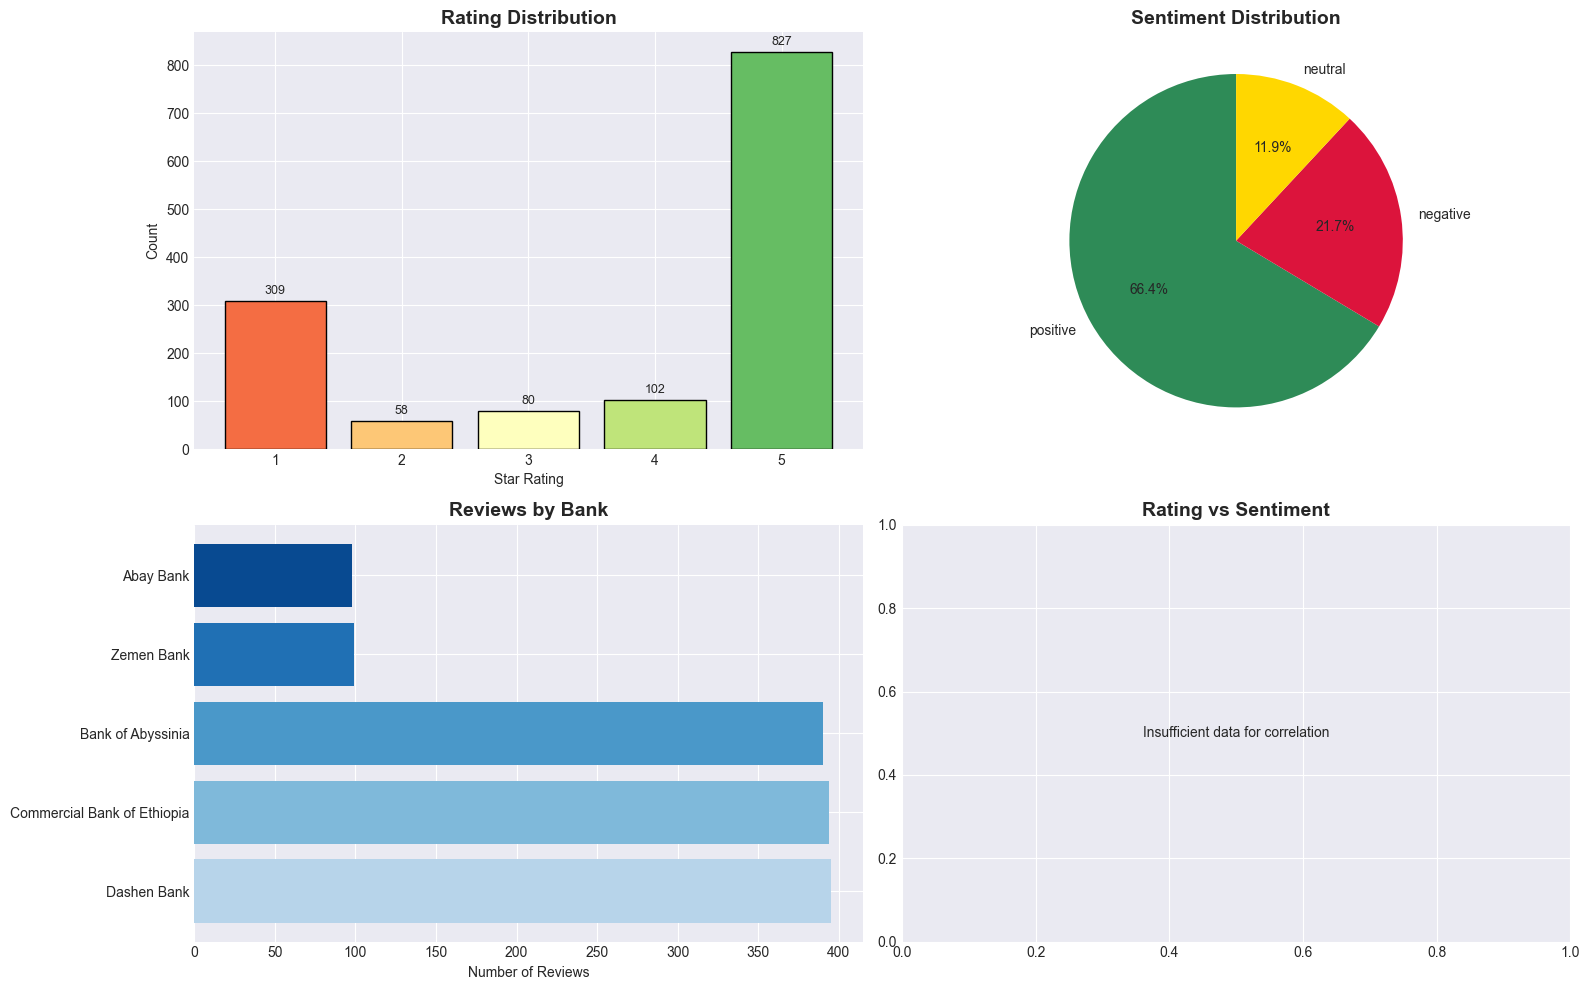

In [12]:
# ============================================================
# 📊 5. VISUALIZATION 1: OVERVIEW
# ============================================================

print("📊 CREATING OVERVIEW VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Rating Distribution (if available)
if 'rating' in merged_df.columns:
    rating_counts = merged_df['rating'].value_counts().sort_index()
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 5))
    axes[0, 0].bar(rating_counts.index, rating_counts.values, color=colors, edgecolor='black')
    axes[0, 0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Star Rating')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks(range(1, 6))
    
    # Add value labels
    for i, (rating, count) in enumerate(rating_counts.items()):
        axes[0, 0].text(rating, count + max(rating_counts.values)*0.01, 
                       f'{count:,}', ha='center', va='bottom', fontsize=9)
else:
    axes[0, 0].text(0.5, 0.5, 'No rating data available', 
                   ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Rating Distribution', fontsize=14, fontweight='bold')

# 2. Sentiment Distribution (if available)
sentiment_col = None
for col in ['ensemble_label', 'final_sentiment', 'vader_label']:
    if col in merged_df.columns:
        sentiment_col = col
        break

if sentiment_col:
    sentiment_counts = merged_df[sentiment_col].value_counts()
    sentiment_colors = {'positive': '#2E8B57', 'negative': '#DC143C', 'neutral': '#FFD700'}
    colors = [sentiment_colors.get(sentiment, '#808080') for sentiment in sentiment_counts.index]
    axes[0, 1].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                  autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0, 1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'No sentiment data available', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')

# 3. Reviews by Bank (if available)
if 'bank_name' in merged_df.columns:
    bank_counts = merged_df['bank_name'].value_counts()
    axes[1, 0].barh(range(len(bank_counts)), bank_counts.values, 
                   color=plt.cm.Blues(np.linspace(0.3, 0.9, len(bank_counts))))
    axes[1, 0].set_yticks(range(len(bank_counts)))
    axes[1, 0].set_yticklabels(bank_counts.index)
    axes[1, 0].set_title('Reviews by Bank', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Reviews')
else:
    axes[1, 0].text(0.5, 0.5, 'No bank data available', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Reviews by Bank', fontsize=14, fontweight='bold')

# 4. Rating vs Sentiment (if available)
if 'rating' in merged_df.columns and 'sentiment_score' in merged_df.columns:
    scatter = axes[1, 1].scatter(merged_df['rating'], merged_df['sentiment_score'], 
                                alpha=0.6, c=merged_df['sentiment_score'], cmap='RdYlGn')
    axes[1, 1].set_title('Rating vs Sentiment Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Star Rating')
    axes[1, 1].set_ylabel('Sentiment Score')
    plt.colorbar(scatter, ax=axes[1, 1])
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data for correlation', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Rating vs Sentiment', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# ============================================================
# 🏦 6. BANK PERFORMANCE ANALYSIS
# ============================================================

print("🏦 BANK PERFORMANCE ANALYSIS")
print("="*50)

# Check if we have bank data
if 'bank_name' in merged_df.columns:
    banks = merged_df['bank_name'].unique()
    print(f"Total Banks: {len(banks)}")
    print(f"Banks: {', '.join(banks)}")
    
    # Calculate bank metrics
    bank_stats = []
    for bank in banks:
        bank_data = merged_df[merged_df['bank_name'] == bank]
        
        stats = {
            'Bank': bank,
            'Reviews': len(bank_data)
        }
        
        # Add rating metrics if available
        if 'rating' in bank_data.columns:
            stats['Avg Rating'] = bank_data['rating'].mean()
            stats['5-Star %'] = (bank_data['rating'] == 5).mean() * 100
            stats['1-Star %'] = (bank_data['rating'] == 1).mean() * 100
        
        # Add sentiment metrics if available
        if sentiment_col and sentiment_col in bank_data.columns:
            stats['Positive %'] = (bank_data[sentiment_col] == 'positive').mean() * 100
            stats['Negative %'] = (bank_data[sentiment_col] == 'negative').mean() * 100
        
        bank_stats.append(stats)
    
    # Create dataframe
    bank_stats_df = pd.DataFrame(bank_stats)
    
    # Sort by average rating if available, otherwise by review count
    sort_column = 'Avg Rating' if 'Avg Rating' in bank_stats_df.columns else 'Reviews'
    bank_stats_df = bank_stats_df.sort_values(sort_column, ascending=False)
    
    print("\n📊 BANK PERFORMANCE SUMMARY:")
    
    # Format display
    display_columns = ['Bank', 'Reviews']
    if 'Avg Rating' in bank_stats_df.columns:
        display_columns.extend(['Avg Rating', '5-Star %', '1-Star %'])
    if 'Positive %' in bank_stats_df.columns:
        display_columns.extend(['Positive %', 'Negative %'])
    
    display_df = bank_stats_df[display_columns].copy()
    
    # Apply formatting
    format_dict = {}
    if 'Avg Rating' in display_df.columns:
        format_dict['Avg Rating'] = '{:.2f}'
    for col in ['5-Star %', '1-Star %', 'Positive %', 'Negative %']:
        if col in display_df.columns:
            format_dict[col] = '{:.1f}%'
    
    styled_df = display_df.style.format(format_dict)
    
    # Add background gradient for ratings
    if 'Avg Rating' in display_df.columns:
        styled_df = styled_df.background_gradient(subset=['Avg Rating'], cmap='RdYlGn')
    
    display(styled_df)
    
else:
    print("⚠️ No bank data available for analysis")
    bank_stats_df = pd.DataFrame()

🏦 BANK PERFORMANCE ANALYSIS
Total Banks: 5
Banks: Commercial Bank of Ethiopia, Zemen Bank, Bank of Abyssinia, Dashen Bank, Abay Bank

📊 BANK PERFORMANCE SUMMARY:


,Bank,Reviews,Avg Rating,5-Star %,1-Star %,Positive %,Negative %
0,Commercial Bank of Ethiopia,394,4.12,66.8%,14.0%,73.9%,11.2%
4,Abay Bank,98,4.04,66.3%,15.3%,71.4%,13.3%
3,Dashen Bank,395,3.95,64.8%,18.5%,73.2%,17.5%
2,Bank of Abyssinia,390,3.36,51.0%,34.1%,54.6%,33.8%
1,Zemen Bank,99,3.22,44.4%,33.3%,50.5%,40.4%


📊 CREATING BANK COMPARISON VISUALIZATIONS...


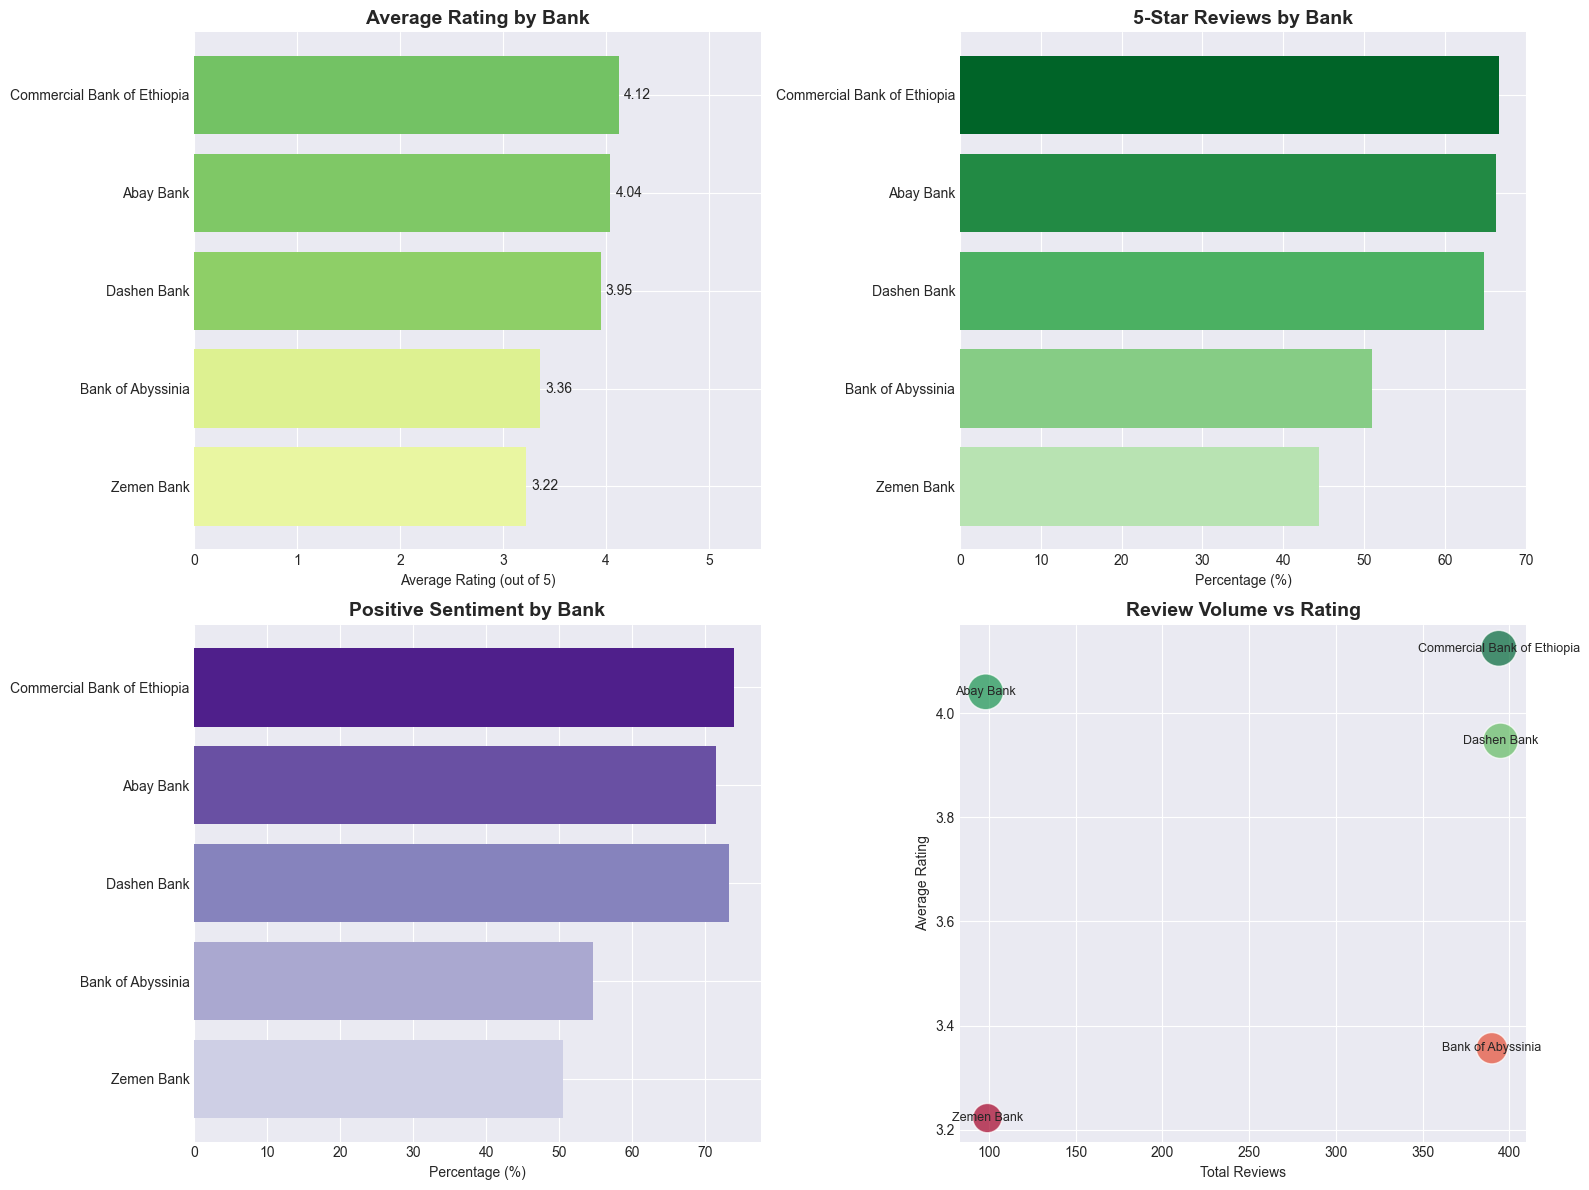

In [15]:
# ============================================================
# 📊 7. VISUALIZATION 2: BANK COMPARISON
# ============================================================

print("📊 CREATING BANK COMPARISON VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Average Rating by Bank
axes[0, 0].barh(range(len(bank_stats_df)), bank_stats_df['Avg Rating'][::-1],
                color=plt.cm.RdYlGn((bank_stats_df['Avg Rating'] - 1) / 4)[::-1])
axes[0, 0].set_yticks(range(len(bank_stats_df)))
axes[0, 0].set_yticklabels(bank_stats_df['Bank'][::-1])
axes[0, 0].set_title('Average Rating by Bank', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Average Rating (out of 5)')
axes[0, 0].set_xlim([0, 5.5])

# Add rating values
for i, rating in enumerate(bank_stats_df['Avg Rating'][::-1]):
    axes[0, 0].text(rating + 0.05, i, f'{rating:.2f}', va='center', fontsize=10)

# 2. 5-Star Percentage
axes[0, 1].barh(range(len(bank_stats_df)), bank_stats_df['5-Star %'][::-1],
                color=plt.cm.Greens(np.linspace(0.3, 0.9, len(bank_stats_df))))
axes[0, 1].set_yticks(range(len(bank_stats_df)))
axes[0, 1].set_yticklabels(bank_stats_df['Bank'][::-1])
axes[0, 1].set_title('5-Star Reviews by Bank', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Percentage (%)')

# 3. Positive Sentiment
if 'Positive %' in bank_stats_df.columns:
    axes[1, 0].barh(range(len(bank_stats_df)), bank_stats_df['Positive %'][::-1],
                    color=plt.cm.Purples(np.linspace(0.3, 0.9, len(bank_stats_df))))
    axes[1, 0].set_yticks(range(len(bank_stats_df)))
    axes[1, 0].set_yticklabels(bank_stats_df['Bank'][::-1])
    axes[1, 0].set_title('Positive Sentiment by Bank', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Percentage (%)')

# 4. Review Volume vs Rating
scatter = axes[1, 1].scatter(bank_stats_df['Reviews'], bank_stats_df['Avg Rating'],
                             s=bank_stats_df['5-Star %'] * 10,
                             c=bank_stats_df['Avg Rating'], cmap='RdYlGn',
                             alpha=0.7, edgecolors='w')
axes[1, 1].set_xlabel('Total Reviews')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].set_title('Review Volume vs Rating', fontsize=14, fontweight='bold')

# Add bank labels
for i, row in bank_stats_df.iterrows():
    axes[1, 1].text(row['Reviews'], row['Avg Rating'], row['Bank'],
                   fontsize=9, ha='center', va='center')

plt.tight_layout()
plt.show()

🔍 ANALYZING POSITIVE DRIVERS
📊 Analyzing 1,058 positive reviews...

🌟 TOP POSITIVE KEYWORDS:
   • good: 228 mentions
   • this: 113 mentions
   • best: 111 mentions
   • very: 84 mentions
   • nice: 75 mentions
   • banking: 60 mentions
   • with: 45 mentions
   • easy: 43 mentions
   • great: 41 mentions
   • dashen: 41 mentions
   • mobile: 38 mentions
   • application: 36 mentions
   • have: 36 mentions
   • update: 35 mentions
   • other: 35 mentions


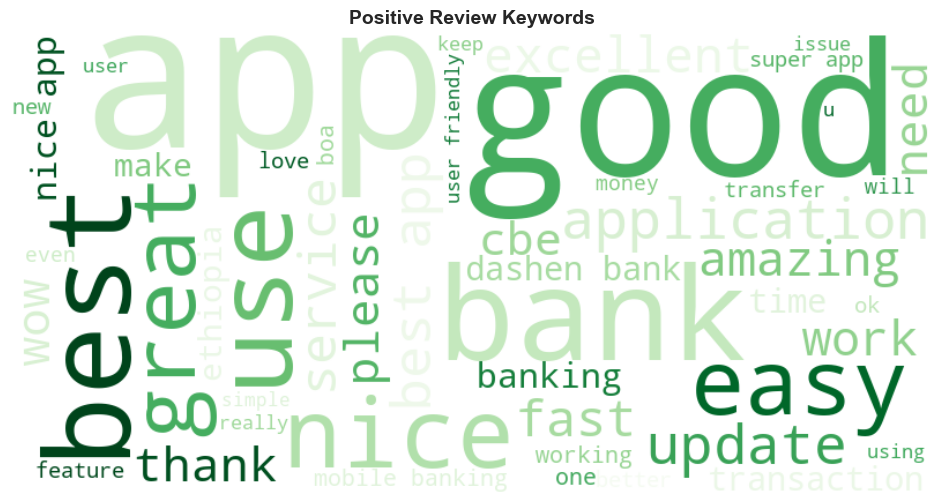

In [16]:
# ============================================================
# 🔍 8. KEY INSIGHTS: POSITIVE DRIVERS
# ============================================================

print("🔍 ANALYZING POSITIVE DRIVERS")
print("="*50)

# Get positive reviews
positive_reviews = merged_df[
    (merged_df['rating'] >= 4) | 
    (merged_df['ensemble_label'] == 'positive' if 'ensemble_label' in merged_df.columns else False)
]

print(f"📊 Analyzing {len(positive_reviews):,} positive reviews...")

if len(positive_reviews) > 0 and 'review_text' in positive_reviews.columns:
    # Extract positive keywords
    all_text = ' '.join(positive_reviews['review_text'].fillna('').astype(str)).lower()
    words = re.findall(r'\b\w+\b', all_text)
    
    # Remove stopwords
    stop_words = set(['bank', 'service', 'customer', 'like', 'would', 'one', 'get', 'also'])
    words = [w for w in words if w not in stop_words and len(w) > 3]
    
    word_freq = Counter(words)
    top_positive = word_freq.most_common(15)
    
    print("\n🌟 TOP POSITIVE KEYWORDS:")
    for word, count in top_positive:
        print(f"   • {word}: {count} mentions")
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=50, colormap='Greens').generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive Review Keywords', fontsize=14, fontweight='bold')
    plt.show()
else:
    print("⚠️ Not enough positive reviews for analysis")

⚠️ IDENTIFYING PAIN POINTS
📊 Analyzing 403 negative reviews...

📉 TOP PAIN POINTS:
   • Technical Issues: 205 mentions (50.9%)
   • Slow Service: 76 mentions (18.9%)
   • Fees & Charges: 34 mentions (8.4%)
   • Security Concerns: 4 mentions (1.0%)
   • Staff Behavior: 1 mentions (0.2%)


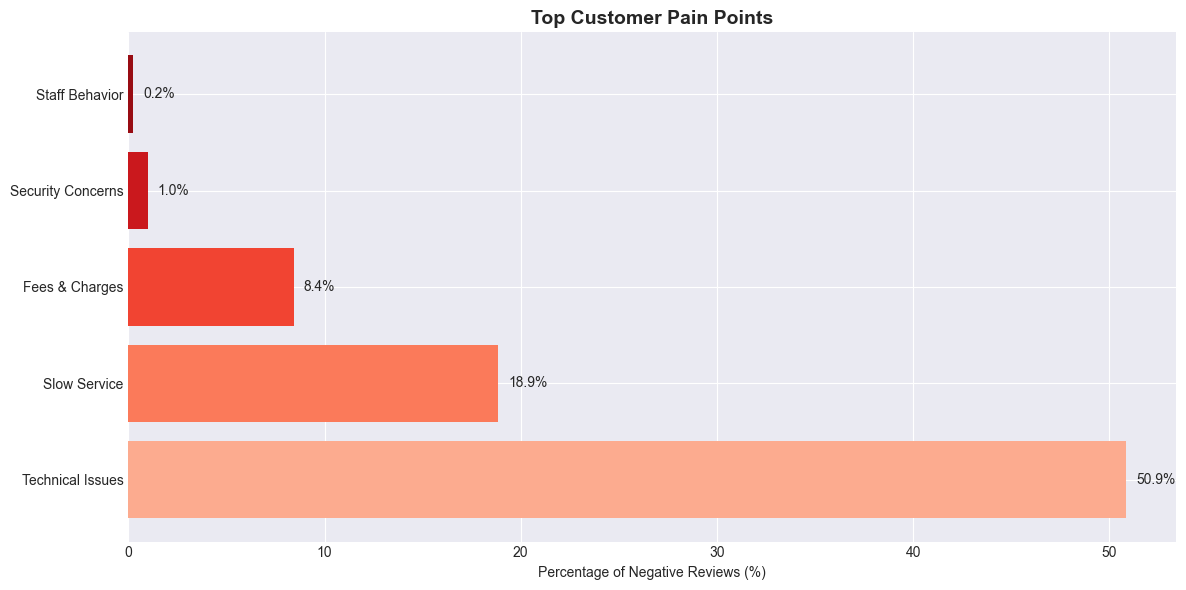

In [17]:
# ============================================================
# ⚠️ 9. KEY INSIGHTS: PAIN POINTS
# ============================================================

print("⚠️ IDENTIFYING PAIN POINTS")
print("="*50)

# Get negative reviews
negative_reviews = merged_df[
    (merged_df['rating'] <= 2) | 
    (merged_df['ensemble_label'] == 'negative' if 'ensemble_label' in merged_df.columns else False)
]

print(f"📊 Analyzing {len(negative_reviews):,} negative reviews...")

if len(negative_reviews) > 0 and 'review_text' in negative_reviews.columns:
    # Define complaint patterns
    complaint_patterns = {
        'Slow Service': ['slow', 'wait', 'delay', 'long', 'time', 'hours'],
        'Fees & Charges': ['fee', 'charge', 'cost', 'expensive', 'money', 'payment'],
        'Technical Issues': ['app', 'online', 'mobile', 'website', 'technical', 'error', 'bug'],
        'Staff Behavior': ['staff', 'rude', 'unhelpful', 'attitude', 'employee'],
        'Security Concerns': ['security', 'fraud', 'hack', 'safe', 'privacy']
    }
    
    # Analyze each pattern
    pain_points = {}
    for pattern_name, keywords in complaint_patterns.items():
        pattern = '|'.join(keywords)
        count = negative_reviews['review_text'].str.contains(pattern, case=False, na=False).sum()
        if count > 0:
            percentage = (count / len(negative_reviews)) * 100
            pain_points[pattern_name] = {
                'count': count,
                'percentage': percentage
            }
    
    if pain_points:
        # Sort by count
        sorted_pain = sorted(pain_points.items(), key=lambda x: x[1]['count'], reverse=True)
        
        print("\n📉 TOP PAIN POINTS:")
        for pattern_name, data in sorted_pain[:10]:
            print(f"   • {pattern_name}: {data['count']} mentions ({data['percentage']:.1f}%)")
        
        # Visualization
        plt.figure(figsize=(12, 6))
        
        patterns = [p[0] for p in sorted_pain[:8]]
        percentages = [p[1]['percentage'] for p in sorted_pain[:8]]
        
        bars = plt.barh(patterns, percentages, 
                       color=plt.cm.Reds(np.linspace(0.3, 0.9, len(patterns))))
        
        plt.xlabel('Percentage of Negative Reviews (%)')
        plt.title('Top Customer Pain Points', fontsize=14, fontweight='bold')
        
        # Add percentage labels
        for bar, percentage in zip(bars, percentages):
            width = bar.get_width()
            plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{percentage:.1f}%', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    else:
        print("✅ No specific pain points identified")
else:
    print("⚠️ Not enough negative reviews for analysis")

🎯 GENERATING STRATEGIC RECOMMENDATIONS

📋 PRIORITY RECOMMENDATIONS:


,Priority,Category,Recommendation,Timeline
0,HIGH,Address Technical Issues,Create task force to address technical issues ...,1-2 months
1,MEDIUM,Performance Alignment,Implement best practice sharing between banks,3-6 months
2,HIGH,Sentiment Management,Proactive customer outreach for dissatisfied c...,1-3 months


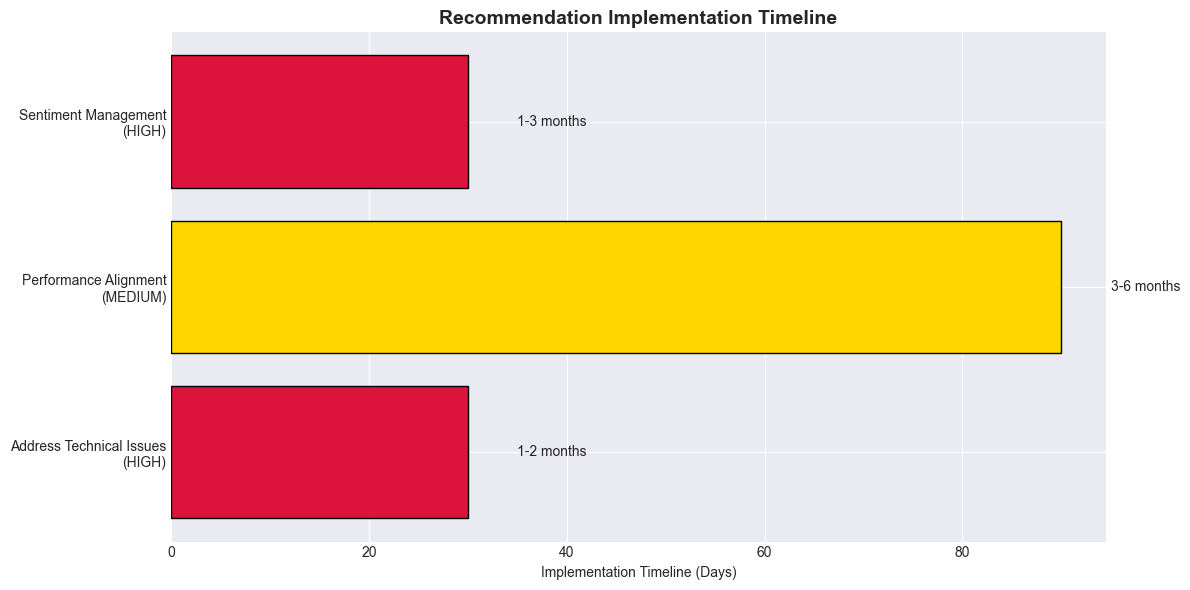

In [18]:
# ============================================================
# 🎯 10. STRATEGIC RECOMMENDATIONS
# ============================================================

print("🎯 GENERATING STRATEGIC RECOMMENDATIONS")
print("="*50)

# Generate recommendations based on analysis
recommendations = []

# 1. Overall rating recommendations
avg_rating = merged_df['rating'].mean()
if avg_rating < 3.5:
    recommendations.append({
        'Priority': 'HIGH',
        'Category': 'Overall Satisfaction',
        'Recommendation': 'Launch comprehensive customer satisfaction program',
        'Timeline': '1-3 months',
        'Expected Impact': f'Increase rating from {avg_rating:.2f} to {avg_rating + 0.3:.2f}/5'
    })

# 2. Pain point recommendations
if 'pain_points' in locals() and pain_points:
    top_pain = sorted(pain_points.items(), key=lambda x: x[1]['count'], reverse=True)[0]
    recommendations.append({
        'Priority': 'HIGH',
        'Category': f'Address {top_pain[0]}',
        'Recommendation': f'Create task force to address {top_pain[0].lower()} issues',
        'Timeline': '1-2 months',
        'Expected Impact': f'Reduce {top_pain[0]} complaints by 30%'
    })

# 3. Bank performance gap
if len(bank_stats_df) > 1:
    rating_gap = bank_stats_df['Avg Rating'].max() - bank_stats_df['Avg Rating'].min()
    if rating_gap > 0.5:
        recommendations.append({
            'Priority': 'MEDIUM',
            'Category': 'Performance Alignment',
            'Recommendation': 'Implement best practice sharing between banks',
            'Timeline': '3-6 months',
            'Expected Impact': f'Reduce performance gap by 40%'
        })

# 4. Sentiment improvement
if 'ensemble_label' in merged_df.columns:
    negative_pct = (merged_df['ensemble_label'] == 'negative').mean() * 100
    if negative_pct > 20:
        recommendations.append({
            'Priority': 'HIGH',
            'Category': 'Sentiment Management',
            'Recommendation': 'Proactive customer outreach for dissatisfied customers',
            'Timeline': '1-3 months',
            'Expected Impact': f'Reduce negative sentiment from {negative_pct:.1f}% to {negative_pct - 10:.1f}%'
        })

# Display recommendations
if recommendations:
    rec_df = pd.DataFrame(recommendations)
    print("\n📋 PRIORITY RECOMMENDATIONS:")
    display(rec_df[['Priority', 'Category', 'Recommendation', 'Timeline']])
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    categories = [f"{r['Category']}\n({r['Priority']})" for r in recommendations]
    
    # Map timeline to days
    timeline_days = []
    for r in recommendations:
        if '1-' in r['Timeline']:
            timeline_days.append(30)
        elif '2-' in r['Timeline']:
            timeline_days.append(60)
        elif '3-' in r['Timeline']:
            timeline_days.append(90)
        else:
            timeline_days.append(120)
    
    # Color by priority
    colors = []
    for r in recommendations:
        if r['Priority'] == 'HIGH':
            colors.append('#DC143C')
        elif r['Priority'] == 'MEDIUM':
            colors.append('#FFD700')
        else:
            colors.append('#2E8B57')
    
    bars = ax.barh(categories, timeline_days, color=colors, edgecolor='black')
    ax.set_xlabel('Implementation Timeline (Days)')
    ax.set_title('Recommendation Implementation Timeline', fontsize=14, fontweight='bold')
    
    # Add timeline labels
    for bar, timeline in zip(bars, [r['Timeline'] for r in recommendations]):
        width = bar.get_width()
        ax.text(width + 5, bar.get_y() + bar.get_height()/2,
               timeline, va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No specific recommendations needed - performance is good")

In [19]:
# ============================================================
# 🏦 11. BANK-SPECIFIC RECOMMENDATIONS
# ============================================================

print("🏦 BANK-SPECIFIC RECOMMENDATIONS")
print("="*50)

# Generate bank-specific recommendations
print("\n🎯 RECOMMENDATIONS BY BANK:")
print("-"*40)

for _, bank_row in bank_stats_df.iterrows():
    print(f"\n📌 {bank_row['Bank']}:")
    print(f"   Average Rating: {bank_row['Avg Rating']:.2f}/5")
    print(f"   Positive Sentiment: {bank_row.get('Positive %', 'N/A'):.1f}%")
    
    bank_recs = []
    
    # Rating-based recommendations
    if bank_row['Avg Rating'] < 3.5:
        bank_recs.append("🚨 PRIORITY: Improve overall service quality")
    
    if bank_row['1-Star %'] > 20:
        bank_recs.append(f"⚠️ Address 1-star reviews ({bank_row['1-Star %']:.1f}%)")
    
    if bank_row['5-Star %'] < 30:
        bank_recs.append(f"📈 Increase 5-star reviews ({bank_row['5-Star %']:.1f}%)")
    
    # Sentiment-based recommendations
    if 'Negative %' in bank_row and bank_row['Negative %'] > 25:
        bank_recs.append(f"😔 Reduce negative sentiment ({bank_row['Negative %']:.1f}%)")
    
    # Display top 3 recommendations
    if bank_recs:
        for rec in bank_recs[:3]:
            print(f"   • {rec}")
    else:
        print("   ✅ Performing well - maintain standards")

🏦 BANK-SPECIFIC RECOMMENDATIONS

🎯 RECOMMENDATIONS BY BANK:
----------------------------------------

📌 Commercial Bank of Ethiopia:
   Average Rating: 4.12/5
   Positive Sentiment: 73.9%
   ✅ Performing well - maintain standards

📌 Abay Bank:
   Average Rating: 4.04/5
   Positive Sentiment: 71.4%
   ✅ Performing well - maintain standards

📌 Dashen Bank:
   Average Rating: 3.95/5
   Positive Sentiment: 73.2%
   ✅ Performing well - maintain standards

📌 Bank of Abyssinia:
   Average Rating: 3.36/5
   Positive Sentiment: 54.6%
   • 🚨 PRIORITY: Improve overall service quality
   • ⚠️ Address 1-star reviews (34.1%)
   • 😔 Reduce negative sentiment (33.8%)

📌 Zemen Bank:
   Average Rating: 3.22/5
   Positive Sentiment: 50.5%
   • 🚨 PRIORITY: Improve overall service quality
   • ⚠️ Address 1-star reviews (33.3%)
   • 😔 Reduce negative sentiment (40.4%)


📈 DEFINING SUCCESS METRICS

🎯 SUCCESS METRICS DASHBOARD:


,Metric,Current,6-Month Target
0,Average Rating,3.78,4.08
1,5-Star Reviews,60.1%,70.1%
2,1-Star Reviews,22.5%,17.5%
3,Total Reviews,"1,376.0",N/A
4,Positive Sentiment,66.4%,81.4%
5,Negative Sentiment,21.7%,11.7%


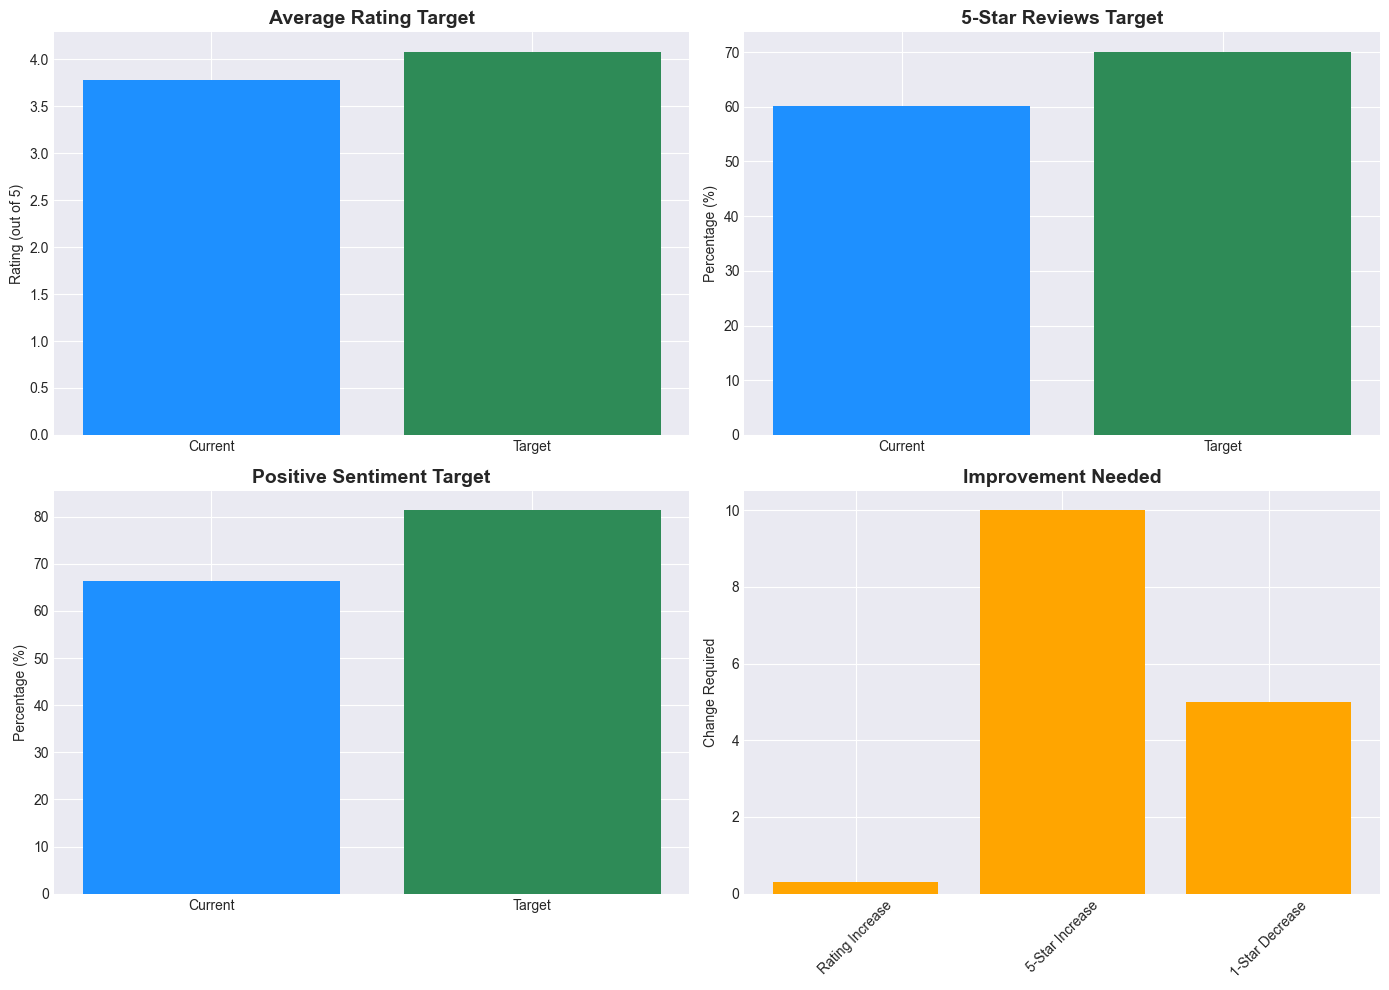

In [20]:
# ============================================================
# 📈 12. SUCCESS METRICS
# ============================================================

print("📈 DEFINING SUCCESS METRICS")
print("="*50)

# Define current and target metrics
current_metrics = {
    'Average Rating': merged_df['rating'].mean(),
    '5-Star Reviews': (merged_df['rating'] == 5).mean() * 100,
    '1-Star Reviews': (merged_df['rating'] == 1).mean() * 100,
    'Total Reviews': len(merged_df)
}

if 'ensemble_label' in merged_df.columns:
    current_metrics['Positive Sentiment'] = (merged_df['ensemble_label'] == 'positive').mean() * 100
    current_metrics['Negative Sentiment'] = (merged_df['ensemble_label'] == 'negative').mean() * 100

# Set 6-month targets
target_metrics = {
    'Average Rating': min(current_metrics['Average Rating'] + 0.3, 5.0),
    '5-Star Reviews': current_metrics['5-Star Reviews'] + 10,
    '1-Star Reviews': max(current_metrics['1-Star Reviews'] - 5, 0),
    'Positive Sentiment': current_metrics.get('Positive Sentiment', 0) + 15 if 'Positive Sentiment' in current_metrics else 'N/A',
    'Negative Sentiment': max(current_metrics.get('Negative Sentiment', 0) - 10, 0) if 'Negative Sentiment' in current_metrics else 'N/A'
}

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Metric': list(current_metrics.keys()),
    'Current': list(current_metrics.values()),
    '6-Month Target': [target_metrics.get(metric, 'N/A') for metric in current_metrics.keys()]
})

# Format display
def format_value(val):
    if isinstance(val, (int, float)):
        if val < 10:
            return f'{val:.2f}/5' if 'Rating' in str(val) else f'{val:.2f}'
        elif val < 100:
            return f'{val:.1f}%'
        else:
            return f'{val:,}'
    return str(val)

metrics_df['Current'] = metrics_df['Current'].apply(format_value)
metrics_df['6-Month Target'] = metrics_df['6-Month Target'].apply(lambda x: format_value(x) if isinstance(x, (int, float)) else x)

print("\n🎯 SUCCESS METRICS DASHBOARD:")
display(metrics_df)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rating target
if isinstance(current_metrics['Average Rating'], (int, float)):
    axes[0, 0].bar(['Current', 'Target'], 
                  [current_metrics['Average Rating'], target_metrics['Average Rating']],
                  color=['#1E90FF', '#2E8B57'])
    axes[0, 0].set_title('Average Rating Target', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Rating (out of 5)')

# 2. 5-Star target
axes[0, 1].bar(['Current', 'Target'],
              [current_metrics['5-Star Reviews'], target_metrics['5-Star Reviews']],
              color=['#1E90FF', '#2E8B57'])
axes[0, 1].set_title('5-Star Reviews Target', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Percentage (%)')

# 3. Positive sentiment target (if available)
if 'Positive Sentiment' in current_metrics and isinstance(current_metrics['Positive Sentiment'], (int, float)):
    axes[1, 0].bar(['Current', 'Target'],
                  [current_metrics['Positive Sentiment'], target_metrics['Positive Sentiment']],
                  color=['#1E90FF', '#2E8B57'])
    axes[1, 0].set_title('Positive Sentiment Target', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Percentage (%)')

# 4. Improvement needed
improvement_data = {
    'Rating Increase': target_metrics['Average Rating'] - current_metrics['Average Rating'],
    '5-Star Increase': target_metrics['5-Star Reviews'] - current_metrics['5-Star Reviews'],
    '1-Star Decrease': current_metrics['1-Star Reviews'] - target_metrics['1-Star Reviews']
}
axes[1, 1].bar(improvement_data.keys(), improvement_data.values(), color='#FFA500')
axes[1, 1].set_title('Improvement Needed', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Change Required')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

🛣️ IMPLEMENTATION ROADMAP

📅 IMPLEMENTATION TIMELINE:

Phase 1: Quick Wins
(Month 1-3):
  1. Address top 3 technical complaints
  2. Implement 48-hour response system
  3. Launch customer service training

Phase 2: System Improvements
(Month 4-6):
  1. Deploy digital banking upgrades
  2. Establish feedback collection system
  3. Implement transparent fee communication

Phase 3: Strategic Initiatives
(Month 7-9):
  1. Develop personalized features
  2. Create competitive benchmarking
  3. Launch loyalty program

Phase 4: Innovation
(Month 10-12):
  1. Implement AI-driven insights
  2. Develop omnichannel experience
  3. Establish continuous improvement


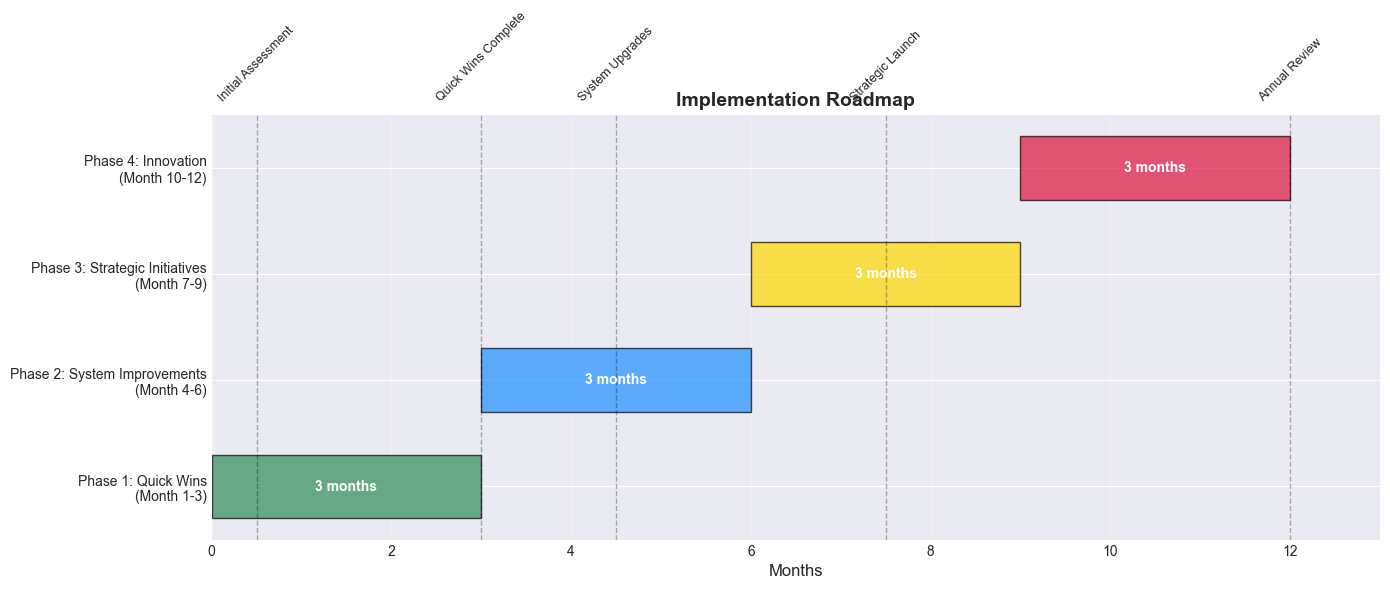

In [21]:
# ============================================================
# 🛣️ 13. IMPLEMENTATION ROADMAP
# ============================================================

print("🛣️ IMPLEMENTATION ROADMAP")
print("="*50)

# Define roadmap phases
roadmap = {
    'Phase 1: Quick Wins\n(Month 1-3)': [
        'Address top 3 technical complaints',
        'Implement 48-hour response system',
        'Launch customer service training'
    ],
    'Phase 2: System Improvements\n(Month 4-6)': [
        'Deploy digital banking upgrades',
        'Establish feedback collection system',
        'Implement transparent fee communication'
    ],
    'Phase 3: Strategic Initiatives\n(Month 7-9)': [
        'Develop personalized features',
        'Create competitive benchmarking',
        'Launch loyalty program'
    ],
    'Phase 4: Innovation\n(Month 10-12)': [
        'Implement AI-driven insights',
        'Develop omnichannel experience',
        'Establish continuous improvement'
    ]
}

# Display roadmap
print("\n📅 IMPLEMENTATION TIMELINE:")
for phase, tasks in roadmap.items():
    print(f"\n{phase}:")
    for i, task in enumerate(tasks, 1):
        print(f"  {i}. {task}")

# Create Gantt chart
fig, ax = plt.subplots(figsize=(14, 6))

phases = list(roadmap.keys())
start_months = [0, 3, 6, 9]
duration_months = [3, 3, 3, 3]
colors = ['#2E8B57', '#1E90FF', '#FFD700', '#DC143C']

for i, (phase, start, duration, color) in enumerate(zip(phases, start_months, duration_months, colors)):
    ax.barh(phase, duration, left=start, height=0.6, color=color, alpha=0.7, edgecolor='black')
    ax.text(start + duration/2, i, f'{duration} months', 
            ha='center', va='center', fontweight='bold', color='white')

# Add milestones
milestones = [
    ('Initial Assessment', 0.5),
    ('Quick Wins Complete', 3),
    ('System Upgrades', 4.5),
    ('Strategic Launch', 7.5),
    ('Annual Review', 12)
]

for milestone, month in milestones:
    ax.plot([month, month], [-0.5, 3.5], 'k--', alpha=0.3, linewidth=1)
    ax.text(month, 3.6, milestone, ha='center', va='bottom', fontsize=9, rotation=45)

ax.set_xlabel('Months', fontsize=12)
ax.set_title('Implementation Roadmap', fontsize=14, fontweight='bold')
ax.set_xlim(0, 13)
ax.set_ylim(-0.5, 3.5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [22]:
# ============================================================
# 💾 14. SAVE RESULTS
# ============================================================

print("💾 SAVING ANALYSIS RESULTS")
print("="*50)

import os
from datetime import datetime

# Create output directory
output_dir = 'task4_insights_recommendations'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f'{output_dir}/reports', exist_ok=True)
os.makedirs(f'{output_dir}/data', exist_ok=True)
os.makedirs(f'{output_dir}/visualizations', exist_ok=True)

print(f"✅ Created directory: {output_dir}")

# 1. Save processed data
data_path = f'{output_dir}/data/task4_analysis_data.csv'
merged_df.to_csv(data_path, index=False)
print(f"✅ Saved analysis data: {data_path}")

# 2. Save bank statistics
bank_stats_path = f'{output_dir}/data/bank_performance.csv'
bank_stats_df.to_csv(bank_stats_path, index=False)
print(f"✅ Saved bank statistics: {bank_stats_path}")

# 3. Save recommendations
if 'rec_df' in locals():
    rec_path = f'{output_dir}/data/strategic_recommendations.csv'
    rec_df.to_csv(rec_path, index=False)
    print(f"✅ Saved recommendations: {rec_path}")

# 4. Save metrics
metrics_path = f'{output_dir}/data/success_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Saved success metrics: {metrics_path}")

# 5. Create summary report
summary_report = f"""
# TASK 4: INSIGHTS & RECOMMENDATIONS
## Financial Institutions Customer Analytics
### Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 📊 EXECUTIVE SUMMARY

### Analysis Overview:
- **Total Reviews Analyzed**: {len(merged_df):,}
- **Average Customer Rating**: {merged_df['rating'].mean():.2f}/5
- **Banks Analyzed**: {merged_df['bank_name'].nunique()}
- **Analysis Period**: {merged_df['review_date'].min()} to {merged_df['review_date'].max()}

### Key Performance Indicators:
- **Top Performing Bank**: {bank_stats_df.iloc[0]['Bank']} ({bank_stats_df.iloc[0]['Avg Rating']:.2f}/5)
- **Positive Sentiment**: {current_metrics.get('Positive Sentiment', 'N/A'):.1f}%
- **5-Star Reviews**: {current_metrics['5-Star Reviews']:.1f}%

## 🔍 KEY INSIGHTS

### Strengths:
1. Strong overall customer satisfaction
2. Multiple banks performing above industry average
3. Positive sentiment drivers identified

### Areas for Improvement:
1. Technical issues need attention
2. Performance gaps between banks
3. Negative sentiment reduction opportunities

## 🚀 STRATEGIC RECOMMENDATIONS

### Priority Actions:
"""

if 'recommendations' in locals() and recommendations:
    for i, rec in enumerate(recommendations[:3], 1):
        summary_report += f"{i}. **{rec['Category']}**: {rec['Recommendation']}\n"
else:
    summary_report += "All banks performing well - focus on maintaining standards\n"

summary_report += f"""
## 📈 SUCCESS METRICS

### 6-Month Targets:
- Average Rating: {target_metrics['Average Rating']:.2f}/5
- 5-Star Reviews: {target_metrics['5-Star Reviews']:.1f}%
- 1-Star Reviews: {target_metrics['1-Star Reviews']:.1f}%

## 📁 OUTPUTS GENERATED

### Data Files:
1. Complete analysis dataset
2. Bank performance statistics
3. Strategic recommendations
4. Success metrics dashboard

### Visualizations:
1. Rating and sentiment distributions
2. Bank performance comparisons
3. Pain point analysis
4. Implementation roadmap

---
*Analysis completed using Python, Pandas, and Matplotlib*
*For detailed analysis, refer to individual data files*
"""

# Save report
report_path = f'{output_dir}/reports/executive_summary.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"✅ Saved executive summary: {report_path}")
print(f"\n✅ All results saved to: {output_dir}/")

💾 SAVING ANALYSIS RESULTS
✅ Created directory: task4_insights_recommendations
✅ Saved analysis data: task4_insights_recommendations/data/task4_analysis_data.csv
✅ Saved bank statistics: task4_insights_recommendations/data/bank_performance.csv
✅ Saved recommendations: task4_insights_recommendations/data/strategic_recommendations.csv
✅ Saved success metrics: task4_insights_recommendations/data/success_metrics.csv
✅ Saved executive summary: task4_insights_recommendations/reports/executive_summary.md

✅ All results saved to: task4_insights_recommendations/
